# Home Credit Default Risk Prediction - Visualization

### 1. Setup shared libraries on path

This setup is done to establish the bridge across custom libraries.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import *

In [92]:
# custom library
import lib.initShared  
import os

In [72]:
#Capture working directory
cwd = os.getcwd()

In [73]:
# Initialize environment to load custom libraries from shared path
lib.initShared.initializeSharedLib(cwd)

### 2 Create Spark session

In [2]:
spark = SparkSession.builder.appName('CheckPyspark').getOrCreate()

### 3 Load data into Spark for processing

<b>The application_train data is loaded into spark in parquet format</b>

In [3]:
data_sp=spark.read.parquet("data/application_train.parquet")

### 4 Importing data cleaning library 

In [74]:
from Data_Cleaning_Lib.CleanLib import DataCleaningLib

In [75]:
cln = DataCleaningLib()

<b> 4.1.We are using 'find_null_values' function to find the null values in the data from the Datacleaning library.

 4.2. Input : data, categorical column ,data count and ratio of the dataset


</b>

In [32]:
for_c=find_null_values(data_sp,categorial_columns,data_sp.count(),ratio=0)

Showing columns with NULL value above: 0
----------------------------------------------------------
NAME_TYPE_SUITE  having NULL VALUES --> 1292
OCCUPATION_TYPE  having NULL VALUES --> 96391
EMERGENCYSTATE_MODE  having NULL VALUES --> 145755


<b>4.3. for_c displays the columns having high null values</b> 

In [35]:
for_c

{'NAME_TYPE_SUITE': 1292,
 'OCCUPATION_TYPE': 96391,
 'EMERGENCYSTATE_MODE': 145755}

## 5. Visualization 

### 5.1 Distribution of null values across the data

#### The piechart shows the distribution of the null value columns in the data.

Input: list of null data

output: Piechart stating  null columns


The column 'Emergencystate_mode' is have more than 50% of the null values in the data
 

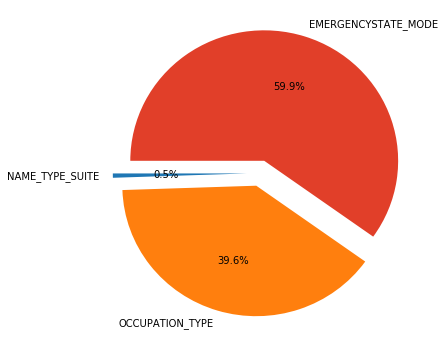

In [91]:
colors = ["#1f77b4","#ff7f0e","#E13F29"]
null_data = list(for_c.keys())
series = pd.Series([for_c[null_data[0]],for_c[null_data[1]],for_c[null_data[2]]] 
                   ,index=null_data,name=' ')
series.plot.pie(figsize=(6, 6),colors= colors,autopct='%1.1f%%',explode=[0.1,0.1,0.1],startangle=180)


#### Inference : The above columns are having the highest null values among other columns. Hence must be taken for imputation.









Now, we are taking EMERGENCYSTATE_MODE from the above piechart and converting it into dictionary. 

Why? Because we using the categories of EMERGENCYSTATE_MODE in the following piechart

In [45]:
count_dict=data_sp.cube('EMERGENCYSTATE_MODE').count().toPandas().set_index('EMERGENCYSTATE_MODE').to_dict()['count']

In [46]:
count_dict

{'Yes': 2328, None: 145755, 'No': 159428}

### 5.2 Distribution of emergencystate_mode column categories

#### The EMERGENCYSTATE_MODE column is distributed to find the percentage of each category

Input: list of null data

output: Piechart stating categories of 'emergency_mode' 

There are 3 dictinct categories in the emergency_mode column - Yes, No and None

Where, the 'No' values is 51 percent and 'Yes' value is only 0.8 percent.
But the 'None' values is 47 percent.


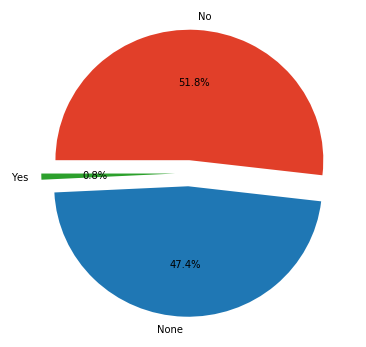

In [66]:
colors = ["#2ca02c","#1f77b4","#E13F29"]
cat_data = list(count_dict.keys())
series = pd.Series([count_dict[cat_data[0]],count_dict[cat_data[1]],count_dict[cat_data[2]]] 
                   ,index=cat_data,name=' ')
series.plot.pie(figsize=(6, 6),colors= colors,autopct='%1.1f%%',explode=[0.1,0.1,0.1],startangle=180)


#### Inference : EMERGENCYSTATE_MODE column contains the high occurance of  'No' value. Hence the 'None' values must be imputed with 'No' 

### 5.3 Distribution of Family status for Repayers and Defaulters 

#### The subplots shows the distribution of Family status of applicants based on their loan repayment

<b>Input: data

output: Countplot stating relation among Familystatus and Target column

</b>


 <b>
 
 Target 0 - denotes loan is paid.
 Target 1 - denotes loan is not paid.
 

</b>

<b>The Family status shows that married people are having highest count in getting loans.</b>

Most of the married people have paid loan i.e above 75 percent
Whereas, 25% of married people have also defaulted loan 

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

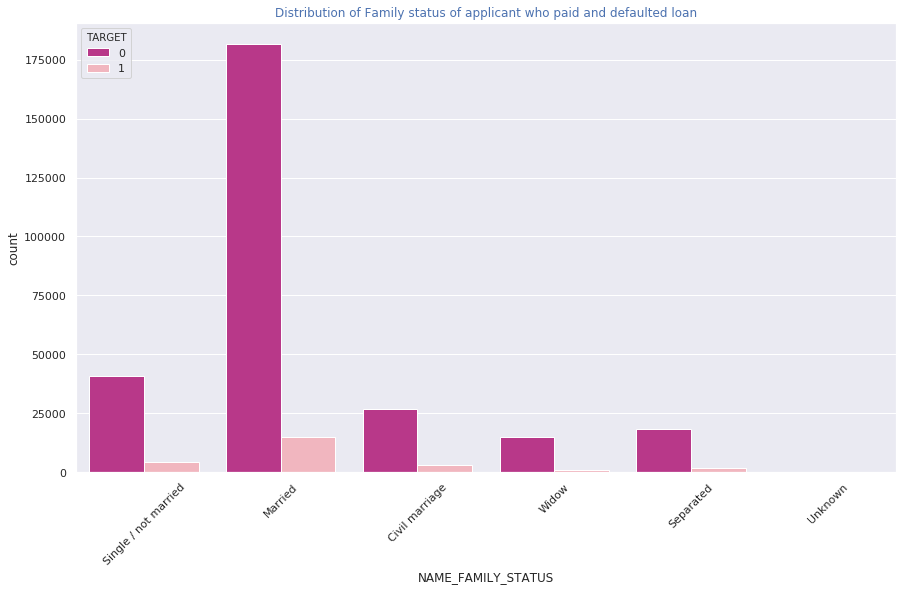

In [124]:
import seaborn as sns
sns.set(rc={'figure.figsize':(14.7,8.27)})
sns.countplot(x="NAME_FAMILY_STATUS", hue="TARGET", data=data, palette='RdPu_r')
plt.title("Distribution of Family status of applicant who paid and defaulted loan",color="b")
plt.xticks(rotation=45)

#### Inference : 
#### The Married people have the highest count in paying loan and some people also defaulted it.
#### Hence 'None' values must be imputed by 'married'  family status.

### 5.4 Correlation among features

####  The data is correlated to find the highly correlated features.

<b>Input: data

output: Heatmap stating correlation among columns</b>

The 'Corr' function is used to find the correlation among the data.

The Top_correlated_features are obtained by finding the Target column having above 30% of correlation

If we have features that are too correlated, we have to remove one, as this may worsen the model.

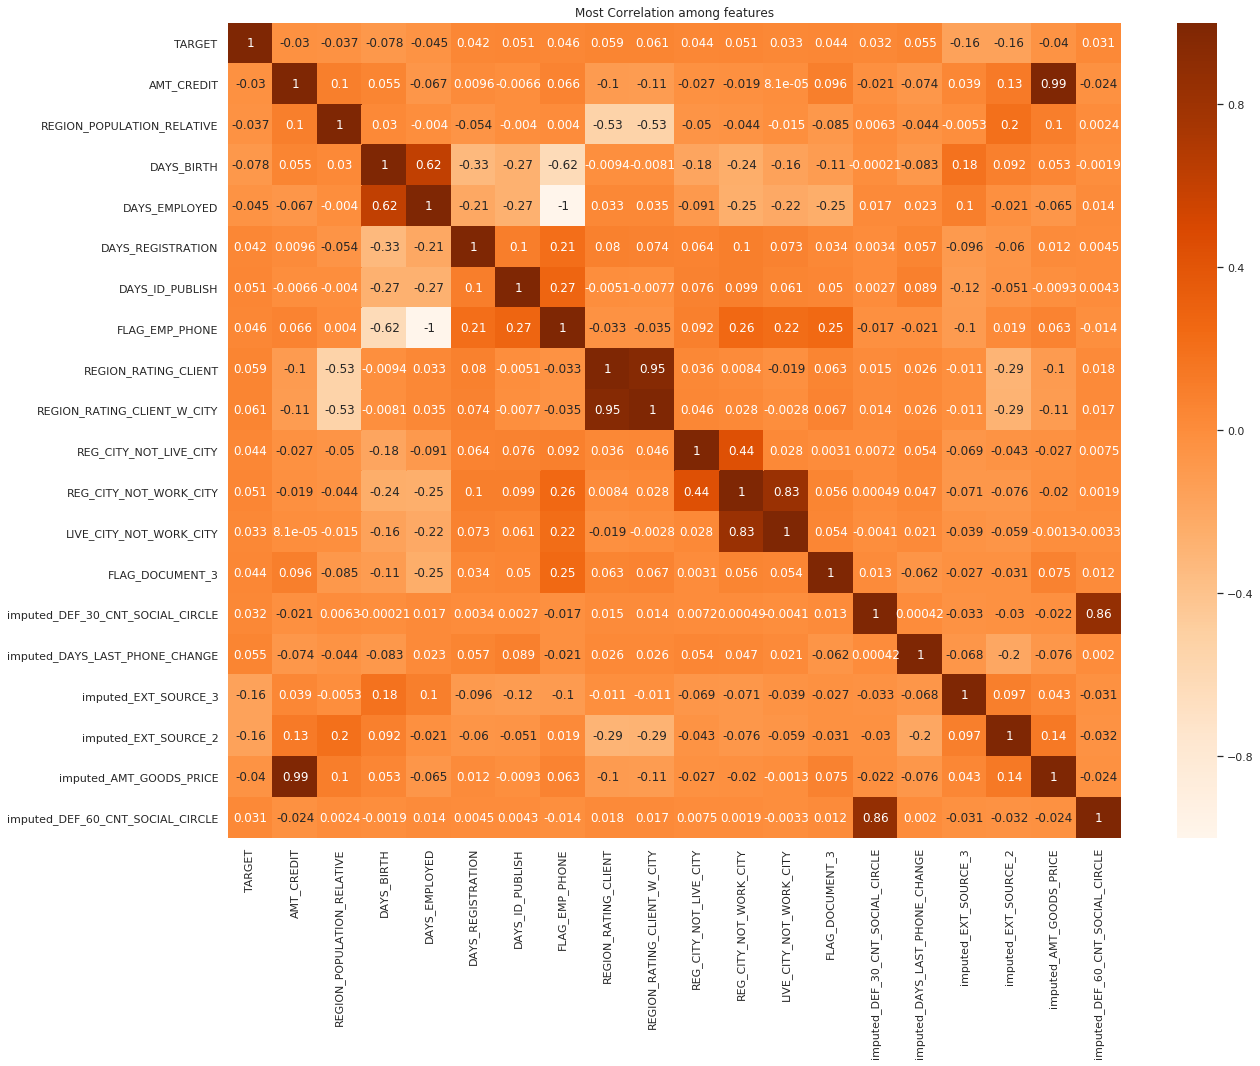

In [117]:
# most correlated features
corrmat = data.corr()
top_corr_features = corrmat.index[abs(corrmat["TARGET"])>=0.03]
plt.figure(figsize=(20,15))
g = sns.heatmap(data[top_corr_features].corr(),annot=True,cmap='Oranges').set_title("Most Correlation among features")

#### Inference : The Highly correlated features are removed to make the data quality better.

#### END OF NOTEBOOK